# Thermal angular spectrum of a chain of SiC spheres
This notebook contains the codes for computing the absorption cross-section and thermal angular spectrum of a chain of four SiC spheres.

Last time edited: 08.04.2025

## Necessary libraries:
- Numpy for vector functions, as well for general math functions
- Matplotlib for plotting
- Treams to compute T-matrices
- Scipy for computing the singular value decomposition and for computing numerical integrals

For T-matrices, the notebook is set by default for the helicity basis. More information in https://tfp-photonics.github.io/treams/treams.html

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import treams as trm
import numpy.linalg as lg
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import interp1d as interpolate
from scipy import integrate
import matplotlib.colors as colors
%pylab inline

trm.config.POLTYPE = 'helicity'

Populating the interactive namespace from numpy and matplotlib


## Electric permittivity function

In [2]:
fdata, epsSiCr, epsSiCim = np.loadtxt('Data_SiC_Larruquert.txt', unpack = True) # Importing data for the dielectric function
epsrint = interpolate(fdata, epsSiCr)
epsimint = interpolate(fdata, epsSiCim)

## Physical constants and global parameters

In [3]:
hbar = 1.05457182e-34 #Dirac's constant in Js
Kb = 1.380649e-23 #Boltzmann's constant in J/K
c0 = 299792458 #Speed of light in vaccuum in m/s

radius = 250e-9 #radius of the sphere in m
distance = 520e-9 #distance between the spheres in nm

mur = 1 #Magnetic permeability of the spheres
eps_bg = 1 #Dielectric constant of the surrounding medium
mu_bg = 1 #Magnetic permeability of the surrounding medium

fvals = np.logspace(np.log10(3e12),np.log10(1.2e14),300) #Range of frequencies in Hz
kvals = 2*np.pi*fvals/c0 #Range of k-vectos
kplot = fvals/(100*c0) #Range of wavenumbers (defined as 1/lambda) in 1/cm

In [5]:
#Here we interpolate the real and imaginary parts of the dielectric function
reps = epsrint(fvals)
rim = epsimint(fvals)

In [4]:
file = open('kplotvals_SiCChain.dat', 'w')
for k in range(len(kplot)):
    file.write('%.10e\n'%kplot[k])
    
file.close()

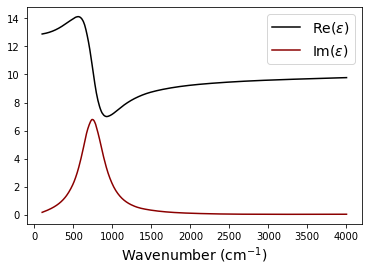

In [6]:
plt.plot(kplot, reps, c = 'k', label = r"Re$(\epsilon)$")
plt.plot(kplot,rim, c = 'darkred',label = r"Im$(\epsilon)$")
plt.xlabel(r'Wavenumber (cm$^{-1}$)', fontsize = 14)
plt.legend(fontsize = 14)

***

## Functions for calculating the T and S matrices and SVD
- The function `Tmatrix` computes the T-matrix up to order `jmax` for the chain of spheres when this is illuminated with light of frequency `f` (in Hz). This function returns a matrix such that its dimension depends on `jmax`, i.e., the maximum multipolar order.
- The function Qmatrix computes the Q-matrix up to order `jmax`. This matrix is given by $$\mathbf{Q} = -2\mathbf{T}-2\mathbf{T}^\dagger-4\mathbf{T}\mathbf{T}^\dagger,$$ as in Eq. (4). This function gives a matrix of the same size as the T-matrix.
- The function `SVD` computes the singular value decomposition of the Q-matrix at each frequency value in the array `fvals`. The function returns an array with two elements: the first one is an matrix whose rows contain the singular values for a single frequency. The second element is matrix whose rows contain the singular vectors for each single frequency. More information can be read below on how to access to the singular values and vectors. 
- `TestAccuracy` is a test function to check which value of jmax suits best for describing the system. The idea is to set a value of `jmax` and compare the trace of the Q-matrix for all $j < j_\text{max}$, that is: $$\frac{\text{Tr}\{\mathbf{Q}(j)\}}{\text{Tr}\{\mathbf{Q}(j_\text{max})\}}$$. As close to 1 this number is for `jmax` big enough, more accurate the computation will be.
***


In [7]:
def Tmatrix(f, jmax):
    kvec = 2*np.pi*f/c0 #converting frequency to wavenumber
    materials = [trm.Material(epsrint(f)+1j*epsimint(f),mur,0), trm.Material(eps_bg,mu_bg,0)]
    positions = [[0,0,-1.5*distance],[0,0,-distance/2],[0,0,distance/2],[0,0,1.5*distance]]
    sph = trm.TMatrix.sphere(jmax, kvec, radius, materials) 
    spheres = [sph, sph,sph, sph]
    chain = trm.TMatrix.cluster(spheres, positions).interaction.solve()
    chain = chain.expand(trm.SphericalWaveBasis.default(jmax))
    return chain.__array__()

def Qmatrix(f, jmax):
    Tmat = Tmatrix(f, jmax)
    return -2*Tmat.T.conjugate() - 2*Tmat - 4*np.matmul(Tmat.T.conjugate(), Tmat)

def SVD(fvals, jmax):
    K, gamma, G = lg.svd(Qmatrix(fvals[0],jmax))
    val1, vec1 = gamma, G
    sorted_levels = [val1]
    sorted_vecs = [vec1]
        
    for f in fvals[1:]:
        K, gamma, G = lg.svd(Qmatrix(f,jmax))
        val2, vec2 = gamma, G
        ov_matrix = np.abs(vec1 @ vec2.T.conj())
        optimal = linear_sum_assignment(-ov_matrix)[1]
        sorted_levels.append(val2[optimal])
        vec1 = vec2[optimal,:]
        sorted_vecs.append(vec1)

    return [sorted_levels, sorted_vecs]

def TestAccuracy():
    acc = []
    f = max(fvals)
    for j in range(1,15): #This test is set for jmax = 15
        tm = Tmatrix(f, j)
        acc.append(np.trace(tm@tm.T.conj()))
    return acc/acc[-1]

In [8]:
TestAccuracy()

array([0.6898593 +6.92972308e-18j, 0.87527176+9.77545236e-18j,
       0.9687046 +9.60636647e-18j, 0.98059805+6.12045956e-18j,
       0.9939646 -2.04527136e-18j, 0.99551231+1.62198908e-17j,
       0.99859498+5.73099580e-18j, 0.99892833+8.17868266e-19j,
       0.99966486+1.42289331e-19j, 0.99974459+1.76285304e-17j,
       0.99992719+6.10234630e-18j, 0.99994757+7.24592065e-18j,
       0.99999445-5.91993003e-18j, 1.        +0.00000000e+00j])

## Planck energy density and absorption cross-section
Here I compute the absorption cross-section of the chain of spheres given by Eq. (19), namely:
$$\sigma = \frac{\pi}{2k^2}\text{Tr}\{\mathbf{Q}\}.$$
This is computed in the function `absxsec`, which receives the frequencies array `fvals` and the maximum value of the multipole expansion `jmax`.

The function `PlanckE` computes the Planck energy density for a given k-vector `k` and temperature `T` , given by $$u(k, T) = \frac{\hbar c k^3}{\pi^2\left(e^{\hbar c k/k_B T} - 1 \right)}.$$

In [9]:
def PlanckE(k, T):
    return hbar*c0*(k**3)/(np.pi**2 * (np.exp(k*hbar*c0/(Kb*T)) - 1))

def absxsec(fvals, jmax):
    sigma = []
    for k in range(len(kvals)):
        kval = 2*np.pi*fvals[k]/c0 #Converting frequency values to k values
        sigma.append(pi*np.real(np.trace(Qmatrix(fvals[k],jmax)))/(2*kval**2))
    return sigma    

In [10]:
sigma = absxsec(fvals, 10) #Absoprtion cross section for jmax = 10
Energy = PlanckE(kvals, 500) #Energy density for T = 500 K

In [11]:
# Here we save the data for Fig 1a
file = open('DataFig1a.dat', "w")

for i in range(len(kplot)):
    file.write("%.6f\t%10.10e\t%10.10e\n"%(kplot[i], 1e12*sigma[i], 2*np.pi*100*Energy[i]))
file.close()

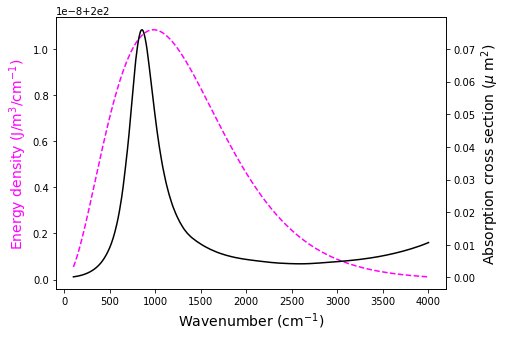

In [44]:
sigma = np.array(sigma)

fig, ax1 = plt.subplots(figsize = (7,5))
ax2 = ax1.twinx()
ax2.plot(kplot, sigma*1e12, c = 'k')
ax1.plot(kplot, 100*2*np.pi**Energy, '--', c = 'fuchsia')
ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize = 14)
ax2.set_ylabel(r'Absorption cross section ($\mu$ m$^2)$', c = 'k', fontsize = 14)
ax1.set_ylabel('Energy density (J/m$^3$/cm$^{-1}$)', c= 'fuchsia',fontsize = 14)

plt.show()

Here we compute the SVD at each frequency in the array `fvals`. The accuracy test showed that $j_\text{max} = 10$ is enough for having an accuracy of 99.9%.
To get the n-th singular value of the $f$-th frequency value in `fvals`, one should use `vals[f][n]`. 
Analogously for the n-th singular vector of the $f$-th frequency value in `fvals`, i.e., `vecs[f][n]`.

In [13]:
vals, vecs = SVD(fvals, 10)

***
## Functions for computing the emission thermal spectrum
- `PW2SW` is the function that transforms a vector from the plane wave basis to the multipolar basis. It takes as arguments the polar angle `theta` and azimuthal angle `phi`, the helicity of the emitted radiation `lam`, and the maximum multipolar order `jmax`. Since the library Treams handles helicity values of 0 for -1 helicity, conversion to the value 1 is necessary. The function `SphericalWaveBasis.default(jmax)` provides the values of $j$ , $m$ and $\lambda$ for each element of the array given the value of `jmax`, which is necessary to know the corresponding values to transform. Since states with opposite polarization are orthogonal, only elements with the same polarization as the one of interest (`lam`) are converted. The function returns a vector with the coefficients, whose dimension is $2j_\text{max}(j_\text{max} + 2).$
- The function `prodDs` calculates the product between the elements of the Wigner matrices $D^j_{m\lambda}$ and the vectors $|s\rangle$ (Eq. (11)). The function takes as parameters the vector of coefficients in the multipolar basis obtained from the PW2SW function, and a singular vector s. Since the library Treams handles helicity values of 0 for -1 helicity, conversion to the value -1 is necessary. The function returns the squared scalar product value between the vectors $D$ and $|s\rangle$.
- The function `KirchhoffsLaw` computes the thermal angular spectrum (Eq. (18)). This function uses the coefficients given by `PW2SW` by considering the direction $-\vec{k}$. This function takes as arguments the angles `theta` and `phi`, the helicity `lam` of the emitted radiation, the singular values `vals` and vectors `vecs`, respectively, the temperature `T`, and the maximum multipolar order `jmax`, and returns the value of the angular thermal spectrum multiplied by `k`, for having the correct units of photon density.
***

In [14]:
def PW2SW(theta, phi, lam, jmax):
    coeff = []
    indices = trm.SphericalWaveBasis.default(jmax)
    for count in range(len(indices)):
        j, m, la = indices[count][1:]
        if la == 0:
            la = -1
        if lam != la:
            coeff.append(0.0)
        else: 
            #Here it is necessary to use the function wignerd for getting the elements of the Wigner's matrices
            coeff.append(np.sqrt((2*j+1)/(4*np.pi))*trm.special.cython_special.wignerd(j,m,la,phi,theta,0))
    return coeff

def prodDs(Dvec, vec, lam, jmax):
    indices = trm.SphericalWaveBasis.default(jmax)
    summ = 0
    for count in range(len(indices)): #Loop over all possible combinacions of j,m and λ
        j, m, la = indices[count][1:]
        if la == 0:
            la = -1
        if la == lam:
            summ += np.conjugate(Dvec[count])*vec[count]
    return abs(summ)**2

def KirchhoffsLaw(theta, phi, lam, kvals, vals, vecs, jmax, T):
    beta = (hbar*c0)/(Kb*T)
    if lam == 0:
        lam = -1
    Dvec = PW2SW(np.pi-theta, phi + np.pi, lam, jmax)
    Expvals = []
    for f in range(len(kvals)): #loop over the frequencies
        Expval = 0
        for i in range(len(vals[0])): #loop over the modes
            Expval += c0*vals[f][i]/(2*np.pi*kvals[f]*(np.exp(beta*kvals[f]) -1)) * prodDs(Dvec, vecs[f][i], lam, jmax)
        Expvals.append(Expval)
    return 2*kvals*Expvals #The factor of 2 accounts for both helicities

## Functions for computing the thermal spectrum as a function of $\theta$ or $\phi$
The functions FunPolar and FunPhi compute the thermal angular spectrum (Eq. (18)) as a function of `theta` and `phi`, respectively. These functions receive an array as a variable (either `theta_range` for having the spectrum as a function of $\theta$ or `phi_range` for having it as a function of $\phi$), the value of `jmax`, the temperature `T` and the arrays of singunar values `vals` and vectors `vecs`, and return a matrix whose dimensions are `len(phi_range)`$\times$ `len(fvals)`, or `len(theta_range)`$\times$ `len(fvals)`.

In [16]:
def FunPolar(theta_range, phi, lam, jmax, T, kvals, vals, vecs):
    aspec_angle = []
    for th in theta_range: #loop over all angles in theta_range
        aspec_angle.append(KirchhoffsLaw(th, phi, lam, kvals, vals, vecs, jmax, T))
    return aspec_angle

def FunPhi(theta, phi_range, lam, jmax, T, kvals,vals, vecs):
    aspec_angle = []
    for p in phi_range: #loop over all angles in phi_range
        aspec_angle.append(KirchhoffsLaw(theta, p, lam, kvals, vals, vecs, jmax, T))
    return aspec_angle    

In [17]:
theta_range = np.linspace(0.001, np.pi, 200) #Array of values for theta
phi_range = np.linspace(0.001, 2*np.pi, 400) #Array of values for phi

#Computing thermal angular spectrum as function of θ with the monochromatic theory for ϕ = π/4
ph_theta = np.array(FunPolar(theta_range, np.pi/4, 1, 10, 500, kvals, vals, vecs))
print('Done')
#Computing thermal angular spectrum as function of ϕ with the monochromatic theory for θ = π/4
ph_phi = np.array(FunPhi(np.pi/4, phi_range, 1, 10, 500, kvals, vals, vecs))
print('Done')

Done
Done


In [18]:
# Here we save the data for Fig 1b
np.savetxt('DataFig1b.dat', 200*np.pi*ph_theta, fmt = '%10.10e')

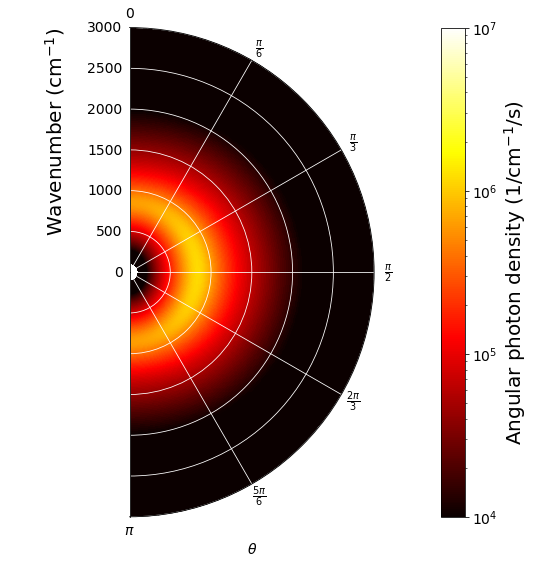

In [29]:
R, Theta = np.meshgrid(kplot, theta_range)

plt.figure(figsize = (10,9))
ax = plt.subplot(111, polar = True)
c = ax.pcolormesh(Theta, R, 200*ph_theta, cmap = 'hot', norm=colors.LogNorm(vmin = 1e4, vmax=1e7))
cbar = plt.colorbar(c, fraction = 0.05, pad = -0.1)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label=r'Angular photon density (1/cm$^{-1}$/s)', size=20)
ax.tick_params(axis ='y', labelsize=14)
ax.tick_params(axis ='x', labelsize=14)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_rlim(0, 3000)
ax.set_yticks([0, 500,  1000, 1500, 2000, 2500, 3000])
ax.grid(True, c = 'white')
ax.set_xticks(np.linspace(0, 7*np.pi/6, 7, endpoint=False))
ax.set_xticklabels(['0', r'$\frac{\pi}{6}$', r'$\frac{\pi}{3}$', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$',
                    r'$\frac{5\pi}{6}$', r'$\pi$'])
ax.set_ylabel(r'Wavenumber (cm$^{-1}$)', labelpad = -60, fontsize = 20, loc = 'top')
ax.set_xlabel(r'$\theta$', fontsize = 14)

plt.show()

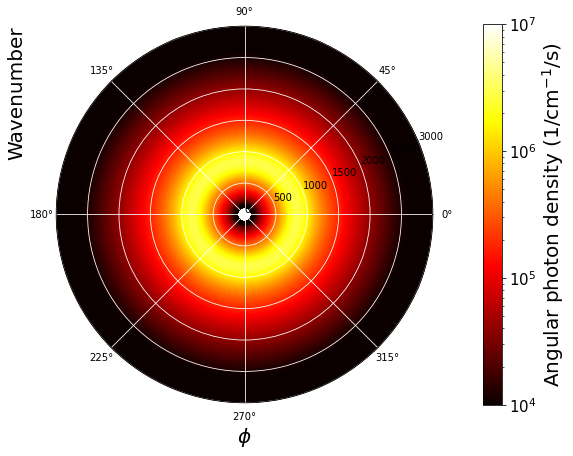

In [28]:
R, Phi = np.meshgrid(kplot, phi_range)

plt.figure(figsize = (9,7))
ax = plt.subplot(111, polar = True)
c = ax.pcolormesh(Phi, R, 200*np.pi*ph_phi, cmap = 'hot', norm =  colors.LogNorm(vmin=1e4, vmax=1e7))
cbar = plt.colorbar(c, pad = 0.1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'Angular photon density (1/cm$^{-1}$/s)', size=20)
ax.set_thetamin(0)
ax.set_thetamax(360)
ax.set_rlim(0, 3000)
ax.set_yticks([0, 500,  1000, 1500, 2000, 2500, 3000])
ax.grid(True, c = 'white')
ax.set_ylabel('Wavenumber', fontsize = 20, labelpad=30, loc = 'top')
ax.set_xlabel(r'$\phi$', fontsize = 20)

plt.show()

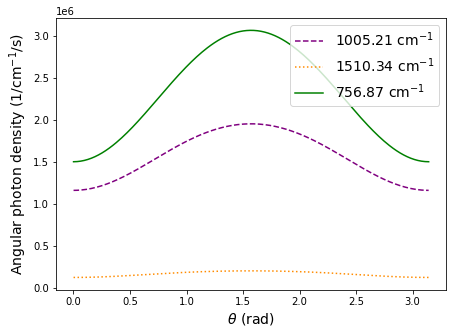

In [43]:
plt.figure(figsize=(7,5))
plt.plot(theta_range, 200*np.pi*ph_theta[:,187], '--', c = 'purple', label = r'1005.21 cm$^{-1}$')
plt.plot(theta_range, 200*np.pi*ph_theta[:,220], ':', c = 'darkorange', label = r'1510.34 cm$^{-1}$')
plt.plot(theta_range, 200*np.pi*ph_theta[:,164], c = 'green', label = r'756.87 cm$^{-1}$')
plt.ylabel(r'Angular photon density (1/cm$^{-1}$/s)', fontsize = 14)
plt.xlabel(r'$\theta$ (rad)', fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [41]:
# Here we save the data for Fig 1c
file = open('DataFig1c.dat', 'w')
for i in range(len(theta_range)):
    file.write("%.5f\t%.10e\t%.10e\t%.10e\n"%(theta_range[i], ph_theta[:, 164][i],ph_theta[:, 187][i],ph_theta[:, 220][i]))
file.close()